# Initial Notebook Tutorial

So this is some text.

Below we can see that python knows how to add up some numbers

In [2]:
1+3

4

And, if we give it some strings, it does something different!

In [3]:
"Hello " + "world!"

'Hello world!'

Do we have state?

In [5]:
variable = 1

let's check

In [7]:
print(variable + 4)

5


And what if we produce an error?

In [8]:
print(variable + "hello")

TypeError: unsupported operand type(s) for +: 'int' and 'str'

Let's check if we can import some module

In [11]:
from pylab import *
from matplotlib.patches import Ellipse

Initialize some data

In [12]:
delta = 45.0 # degrees

angles = arange(0, 360+delta, delta)
ells = [Ellipse((1, 1), 4, 2, a) for a in angles]

a = subplot(111, aspect='equal')

for e in ells:
    e.set_clip_box(a.bbox)
    e.set_alpha(0.1)
    a.add_artist(e)

xlim(-2, 4)
ylim(-1, 3)

(-1, 3)

And plot!

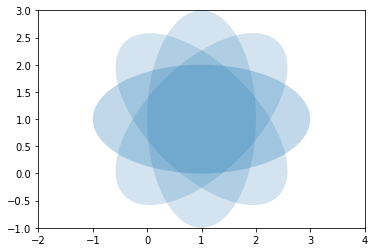

In [13]:
show()

That's nice. We should see now if we can include some code as example.